# Timelag Analysis
Build a small module for easily producing timelag maps from stacks of AIA images. Use primarily with simulations, but could be used with observations as well.

In [2]:
import os

import h5py
import numpy as np
from scipy.interpolate import splev
import dask
import dask.distributed
import matplotlib.pyplot as plt
import matplotlib.colors
import sunpy
from sunpy.map import Map,GenericMap
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.utils.console import ProgressBar

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA

from timelags import AIATimeLags

%matplotlib inline

In [3]:
client = dask.distributed.Client()
client

Client Scheduler: tcp://127.0.0.1:38040 Dashboard: http://127.0.0.1:8787,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


In [4]:
aia_ieq = InstrumentSDOAIA([0,10000]*u.s)
aia_ieq.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis/cooling/ieq/SDO_AIA_counts.h5'
aia_nei = InstrumentSDOAIA([0,10000]*u.s)
aia_nei.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis/cooling/nei/SDO_AIA_counts.h5'

In [6]:
tl_ieq = AIATimeLags(aia_ieq, '/storage-home/w/wtb2/data/timelag_synthesis/cooling/ieq/')

FloatProgress(value=0.0)

In [5]:
tl_nei = AIATimeLags(aia_nei, '/storage-home/w/wtb2/data/timelag_synthesis/cooling/nei/')

FloatProgress(value=0.0)

## 1D Correlations

In [ ]:
xc,yc = -280*u.arcsec,-140*u.arcsec
dx,dy = 5*u.arcsec,5*u.arcsec
xrange = (xc-dx/2,yc-dy/2)
yrange = (xc+dx/2,yc+dy/2)

In [ ]:
plt.figure(figsize=(10,10))
for i,channel in enumerate(aia_ieq.channels):
    ts_ieq = tl_ieq.make_timeseries(tl_ieq.cubes,channel['name'],xrange,yrange)
    plt.plot(aia_ieq.observing_time,
             ts_ieq,#/ts_ieq.max(),
             label=channel['name'],ls='-',color=f'C{i}')
    ts_nei = tl_nei.make_timeseries(tl_nei.cubes,channel['name'],xrange,yrange)
    plt.plot(aia_nei.observing_time,
             ts_nei,#/ts_nei.max(),
             ls='--',color=f'C{i}')
plt.legend()
#plt.xlim(0,2000)
plt.yscale('log')
plt.xscale('log')

In [ ]:
plt.figure(figsize=(10,8))
for i,p in enumerate([('335','171'),('94','171'),('94','335'),('335','211'),('193','171'),('171','131')]):
    cc_ieq = tl_ieq.correlation_1d(*p, xrange, yrange)
    cc_nei = tl_nei.correlation_1d(*p, xrange, yrange)
    plt.plot(tl_ieq.timelags,cc_ieq/cc_ieq.max(),color=f'C{i}',ls='-',label='{}-{}'.format(*p))
    plt.plot(tl_nei.timelags,cc_nei/cc_nei.max(),color=f'C{i}',ls='--')
plt.axvline(x=0,ls='--',color='k')
plt.xlim([-6e3,6e3])
plt.legend()

## 2D Timelag Maps

In [15]:
cc_map_ieq_335_171,tl_map_ieq_335_171 = tl_ieq.make_timelag_map('335','171')

In [18]:
cc_map_ieq_94_171,tl_map_ieq_94_171 = tl_ieq.make_timelag_map('94','171')

In [28]:
cc_map_ieq_171_131,tl_map_ieq_171_131 = tl_ieq.make_timelag_map('171','131')

In [7]:
cc_map_nei_335_171,tl_map_nei_335_171 = tl_nei.make_timelag_map('335','171')

In [11]:
cc_map_nei_94_171,tl_map_nei_94_171 = tl_nei.make_timelag_map('94','171')

In [21]:
cc_map_nei_171_131,tl_map_nei_171_131 = tl_nei.make_timelag_map('171','131')

tornado.application - ERROR - Exception in callback <bound method Nanny.memory_monitor of <Nanny: tcp://127.0.0.1:40451, threads: 1>>
Traceback (most recent call last):
  File "/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/tornado/ioloop.py", line 1026, in _run
    return self.callback()
  File "/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/distributed/nanny.py", line 254, in memory_monitor
    self.process.process.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'


First, look at the NEI maps for both the 335-171 and 94-171 pairs.

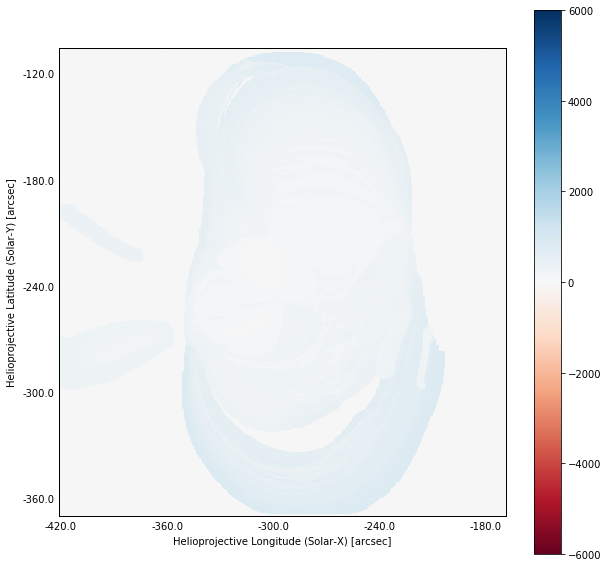

In [22]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection=tl_map_nei_171_131)
tl_map_nei_171_131.plot(vmin=-6e3,vmax=6e3,axes=ax,title=False)
plt.colorbar()

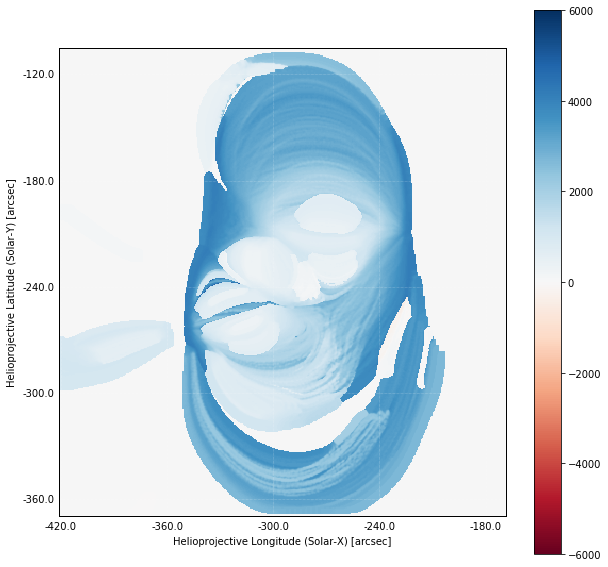

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection=tl_map_nei_335_171)
tl_map_nei_335_171.plot(vmin=-6e3,vmax=6e3,axes=ax,title=False)
plt.colorbar()

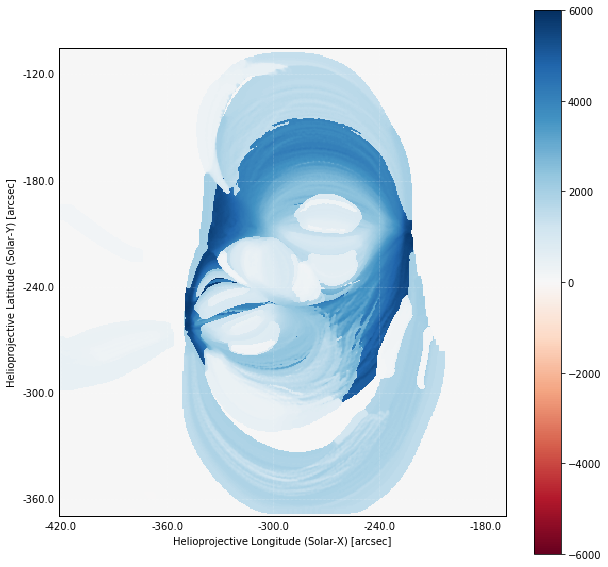

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection=tl_map_nei_94_171)
tl_map_nei_94_171.plot(vmin=-6e3,vmax=6e3,axes=ax,title=False)
plt.colorbar()

Now look at the equilibrium maps.

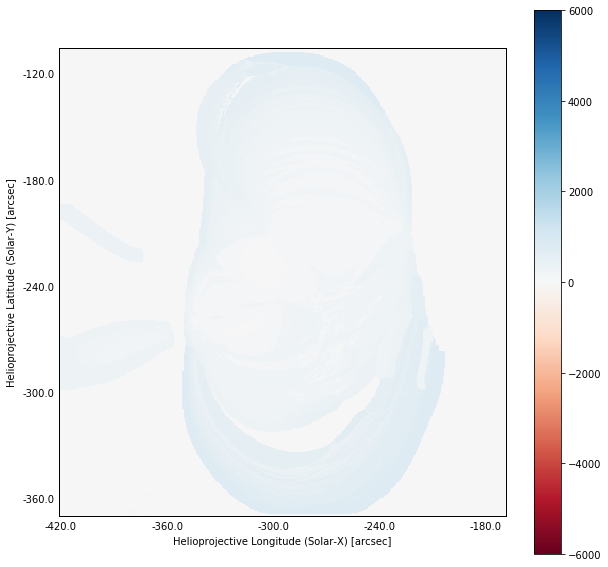

In [29]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection=tl_map_ieq_171_131)
tl_map_ieq_171_131.plot(vmin=-6e3,vmax=6e3,axes=ax,title=False)
plt.colorbar()

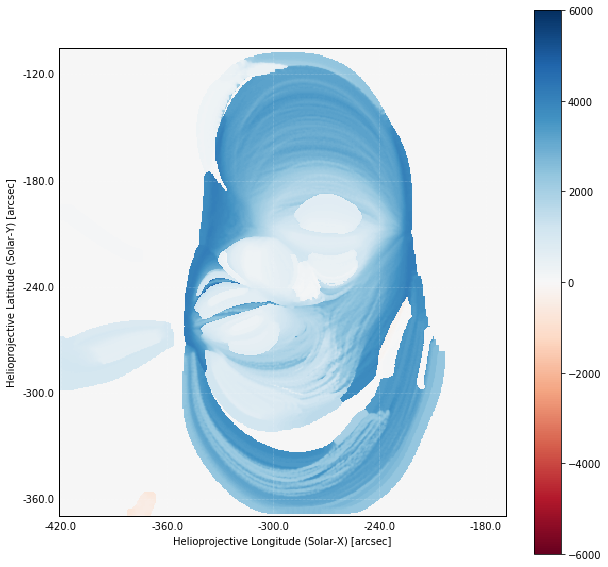

In [17]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection=tl_map_ieq_335_171)
tl_map_ieq_335_171.plot(vmin=-6e3,vmax=6e3,axes=ax,title=False)
plt.colorbar()

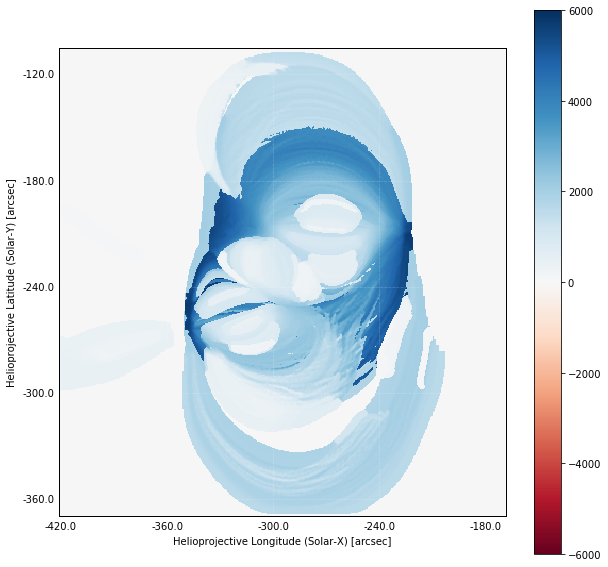

In [19]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection=tl_map_ieq_94_171)
tl_map_ieq_94_171.plot(vmin=-6e3,vmax=6e3,axes=ax,title=False)
plt.colorbar()

Finally, compare them on a histogram

(-6000.0, 6000.0)

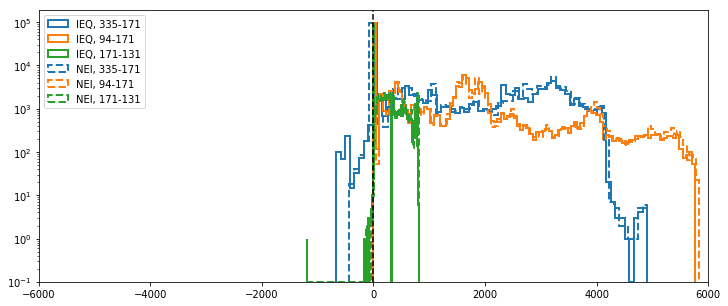

In [30]:
params = {'log':True,'bins':'fd','histtype':'step','lw':2,'normed':False}
plt.figure(figsize=(12,5))
plt.hist(tl_map_ieq_335_171.data.flatten(),**params,label='IEQ, 335-171',color='C0',ls='-')
plt.hist(tl_map_ieq_94_171.data.flatten(),**params,label='IEQ, 94-171',color='C1',ls='-')
plt.hist(tl_map_ieq_171_131.data.flatten(),**params,label='IEQ, 171-131',color='C2',ls='-')
plt.hist(tl_map_nei_335_171.data.flatten(),**params,label='NEI, 335-171',color='C0',ls='--')
plt.hist(tl_map_nei_94_171.data.flatten(),**params,label='NEI, 94-171',color='C1',ls='--')
plt.hist(tl_map_nei_171_131.data.flatten(),**params,label='NEI, 171-131',color='C2',ls='--')
plt.axvline(x=0,ls='--',color='k')
plt.legend()
plt.xlim(-6e3,6e3)

In [ ]:
client.close()